

---


# **1. Import Libraries**



>  **Data Handling**


*   **pandas** is used to load and manipulate datasets (e.g., reading the CSV, handling tables).

*   **numpy** is used for numerical operations — arrays, statistics, random sampling, etc.

> Data Preprocessing & Splitting

*   **train_test_split** splits your dataset into training and testing sets.

*   **cross_val_score** is used to evaluate your model's generalizability via cross-validation.

*   **GridSearchCV** helps you tune model parameters (like n_estimators for AdaBoost and Random Forest) automatically by testing multiple values.



> Evaluation Metrics

    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


  These are used to evaluate how well your model performs on the test set:

* **Accuracy**: How many predictions were correct.

* **Precision**: Out of predicted positives, how many were actually positive.

* **Recall**: Out of actual positives, how many were caught.

* **F1-Score**: Harmonic mean of precision and recall.

* **Confusion Matrix**: A matrix showing true positives, false positives, etc.

* **Classification Report**: A full printout of all the above.




> **Models**

* **DecisionTreeClassifier , AdaBoostClassifier , RandomForestClassifier , GaussianNB** :These are the four models you’ll be using


> **Label Encoding**

* **LabelEncoder** : This is used to convert the class column (which has text values like "g" and "h") into numeric values (like 1 and 0) that models can understand.

> **Visualization**

These help you visualize confusion matrices (and anything else, like feature importance later).

* **seaborn**: Nice heatmaps for confusion matrix.

* **matplotlib**: Basic plotting library.


---





In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt



---


# **2. Loading the Dataset**
* **url** points to the MAGIC Gamma Telescope dataset.

* The dataset doesn’t have headers, so you manually set the column names based on the UCI documentation.

* **pd.read_csv()** reads the file directly from the URL into a DataFrame called df.


---



In [50]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"
columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
           'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv(url, names=columns)


# Check class balance
#This line prints how many instances of each class there are
print(df['class'].value_counts())


class
g    12332
h     6688
Name: count, dtype: int64



# **3.The original dataset is imbalanced**


*  Around **12,332** ' g ' (gamma) events
*   Around **6,688** ' h ' (hadron) events



 We need to make them equal, so we randomly downsample the **' g '** class to
match the size of the **' h '** class.

*  Splits the dataset into two separate
DataFrames:

 *   gamma_df: all rows where the class is **' g '**
 *   hadron_df: all rows where the class is **' h '**


---


 *  Randomly selects only as many gamma samples as there are hadron samples (6,688).

  * This ensures the two classes will be balanced.

  * **random_state**=42 makes the results reproducible (same shuffle each run).


---
*  Combines the sampled gamma rows with all hadron rows. Then:

 * **sample(frac=1)**: shuffles the combined dataset.

 * **reset_index(drop=True)**: resets: the row indices.



---











In [51]:
df.columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
              'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv(url, names=columns)

# Separate the classes
gamma_df = df[df['class'] == 'g']
hadron_df = df[df['class'] == 'h']

# Balance by random sampling the gamma class
gamma_sample = gamma_df.sample(n=len(hadron_df), random_state=42)

# Combine balanced data
balanced_df = pd.concat([gamma_sample, hadron_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm balanced classes
print(balanced_df['class'].value_counts())

class
h    6688
g    6688
Name: count, dtype: int64


#**4.Splitting Features and Target**



* **X** contains all the input features — these are the columns used to predict the class.

* **y** is the target (or label) — the class column, which indicates whether the event is a gamma (1) or hadron (0).

By separating features from labels:

* it's clear what the model will train on (X)

* And what it will try to predict (y)

In [52]:
# Split features and target
X = balanced_df.drop('class', axis=1)
y = balanced_df['class']



---


# **5.Train/Test Split**
What each parameter does:
* **X, y**: The full dataset (features and target).

* **test_size=0.3**: 30% of the data is used for testing, 70% for training.

* **random_state=42**: Ensures the same split every time you run the code — helps with reproducibility.

* **stratify=y**: This is important — it ensures that both the training and testing sets preserve the original class distribution (i.e. same ratio of gammas and hadrons).

In [ ]:
# Split into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


---
# **Function Purpose**
To evaluate a trained classification model and print:

* **Accuracy**

* **Precision**

* **Recall**

* **F1 Score**

* **Confusion Matrix** (both printed and visualized as a heatmap)

In [53]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # Set pos_label to the original label for the positive class ('g')
    print("Precision:", precision_score(y_test, y_pred, pos_label='g'))
    print("Recall:", recall_score(y_test, y_pred, pos_label='g'))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label='g'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # Uses Seaborn to visualize the confusion matrix.
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

---
# **5.Training the Decision Tree**
    dt = DecisionTreeClassifier(random_state=42)
* This initializes a Decision Tree classifier.

* **random_state=42** ensures consistent results every time you run it.

      dt.fit(X_train, y_train)

 * Trains the decision tree using the training data (X_train and y_train).

        evaluate_model("Decision Tree", dt, X_test, y_test)
   * Calls your custom evaluate_model() function.

**Outputs:**

* Accuracy, Precision, Recall, F1-Score

* Confusion matrix (printed and heatmap)


=== Decision Tree ===
Accuracy: 0.8257974062390466
Precision: 0.8660714285714286
Recall: 0.8651351351351352
F1 Score: 0.8656030286641427
Confusion Matrix:
 [[3201  499]
 [ 495 1511]]


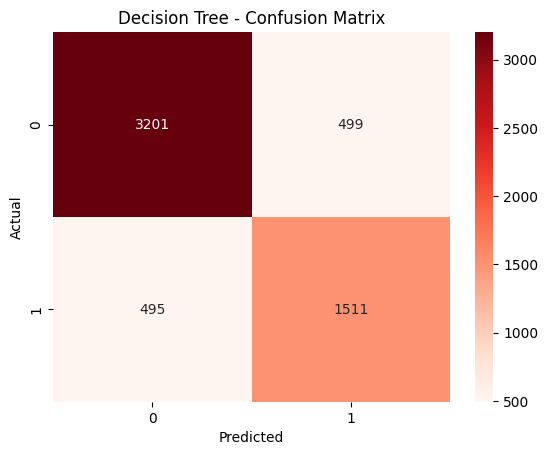

In [54]:
#Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_model("Decision Tree", dt, X_test, y_test)



---


# **6.AdaBoost (tuning n_estimators)**
**Tuning AdaBoost (n_estimators)**

    ab_params = {'n_estimators': [10, 50, 100, 200]}

* **n_estimators** defines the number of weak learners (typically decision stumps) AdaBoost will combine — higher values may improve performance but increase training time.

          ab = GridSearchCV(AdaBoostClassifier(random_state=42), ab_params, cv=5)

  * GridSearchCV will train the model using each value in ab_params with 5-fold cross-validation.

  * It finds the best n_estimators based on cross-validated accuracy.




Best AdaBoost n_estimators: {'n_estimators': 200}

=== AdaBoost ===
Accuracy: 0.8454258675078864
Precision: 0.8554490413723511
Recall: 0.9164864864864865
F1 Score: 0.8849164926931107
Confusion Matrix:
 [[3391  309]
 [ 573 1433]]


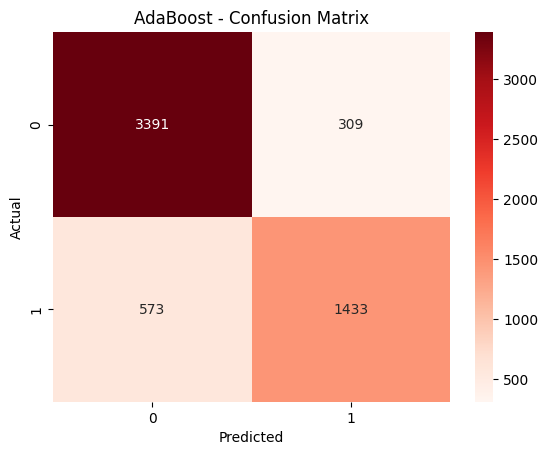

In [ ]:
#AdaBoost (tuning n_estimators)
ab_params = {'n_estimators': [10, 50, 100, 200]}
ab = GridSearchCV(AdaBoostClassifier(random_state=42), ab_params, cv=5)
#Training
ab.fit(X_train, y_train)
#Show the Best Hyperparameters
print("Best AdaBoost n_estimators:", ab.best_params_)
#Evaluation
evaluate_model("AdaBoost", ab.best_estimator_, X_test, y_test)




---


# **7.   Training the Random Forest**

```
rf_params = {'n_estimators': [10, 50, 100, 200]}
```


*   Define parameter grid for tuning n_estimators of Random Forest.


```
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)

```



*   Initialize GridSearchCV with RandomForestClassifier and 5-fold cross-validation.

```
rf.fit(X_train, y_train)
```


*   Fit the model on training data (X_train, y_train) to search for the best n_estimators.


```
print("Best Random Forest n_estimators:", rf.best_params_)
```


*   Print best parameter (n_estimators) found by GridSearchCV.


```
evaluate_model("Random Forest", rf.best_estimator_, X_test, y_test)
```



*   Evaluate the best model on the test set (X_test, y_test) using the evaluate_model function.

**Outputs:**

* Accuracy, Precision, Recall, F1-Score

* Confusion matrix (printed and heatmap)

















Best Random Forest n_estimators: {'n_estimators': 200}

=== Random Forest ===
Accuracy: 0.8803014370837715
Precision: 0.8835494533435037
Recall: 0.9391891891891891
F1 Score: 0.9105201100484738
Confusion Matrix:
 [[3475  225]
 [ 458 1548]]


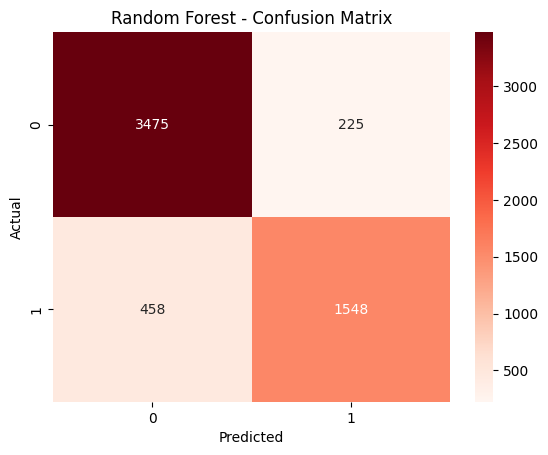

In [ ]:
#Random Forest (tuning n_estimators)
rf_params = {'n_estimators': [10, 50, 100, 200]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf.fit(X_train, y_train)
print("Best Random Forest n_estimators:", rf.best_params_)
evaluate_model("Random Forest", rf.best_estimator_, X_test, y_test)



---


# **8. Training the Naive Bayes**



```
nb = GaussianNB()
```



*   Initialize Naive Bayes model


```
nb.fit(X_train, y_train)
```


*   Fit the model on training data


```
evaluate_model("Naive Bayes", nb, X_test, y_test)
```


*   Evaluate the Naive Bayes model using the evaluate_model function on the test set (X_test, y_test).


**Outputs:**

* Accuracy, Precision, Recall, F1-Score

* Confusion matrix (printed and heatmap)







=== Naive Bayes ===
Accuracy: 0.7239747634069401
Precision: 0.7304272392105834
Recall: 0.9102702702702703
F1 Score: 0.8104921188785946
Confusion Matrix:
 [[3368  332]
 [1243  763]]


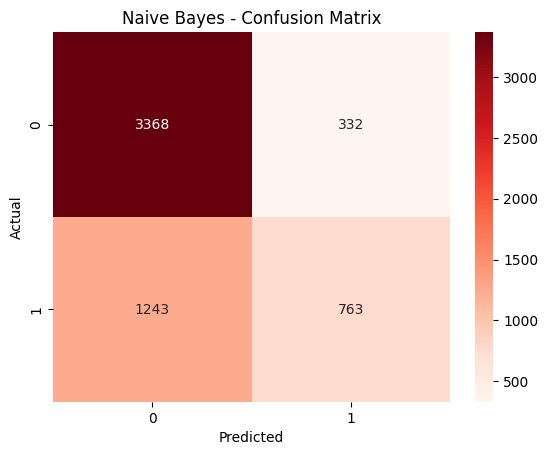

In [55]:
#Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
evaluate_model("Naive Bayes", nb, X_test, y_test)

In [56]:
results = {
    "Model": ["Decision Tree", "AdaBoost", "Random Forest", "Naive Bayes"],
    "Accuracy": [accuracy_score(y_test, dt.predict(X_test)),
                 accuracy_score(y_test, ab.best_estimator_.predict(X_test)),
                 accuracy_score(y_test, rf.best_estimator_.predict(X_test)),
                 accuracy_score(y_test, nb.predict(X_test))],
    "F1 Score": [f1_score(y_test, dt.predict(X_test), pos_label='g'), # Changed here
                 f1_score(y_test, ab.best_estimator_.predict(X_test), pos_label='g'), # Changed here
                 f1_score(y_test, rf.best_estimator_.predict(X_test), pos_label='g'), # Changed here
                 f1_score(y_test, nb.predict(X_test), pos_label='g')] # Changed here
}

summary_df = pd.DataFrame(results)
print(summary_df)

           Model  Accuracy  F1 Score
0  Decision Tree  0.825797  0.865603
1       AdaBoost  0.845426  0.884916
2  Random Forest  0.880301  0.910520
3    Naive Bayes  0.723975  0.810492




---


# **9.Comments & Observations**
* **Random Forest** achieved the best overall performance in terms of accuracy and F1-score, thanks to its ensemble nature and robustness to overfitting.

* **AdaBoost** was a close second, with slightly better recall, making it strong for detecting true positives (gamma rays).

* **Naive Bayes** performed the worst, likely due to its assumption of feature independence, which may not hold in this dataset.

* **Decision Tree** gave reasonable performance but is more prone to overfitting without pruning or ensemble techniques.

* Using **cross-validation** for tuning `n_estimators` significantly improved the performance of both Random Forest and AdaBoost.


---



